In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Importing the databases that we need


In [ ]:
# loading in statistics for college players
college_stats = pd.read_csv('all_college_data.csv')

# removing college players that were not drafted
college_stats = college_stats[college_stats['Pick'].notna()]

# dropping all the coloumns that are not going to be used in estimation
cols = ['Player', 'Pick', 'GP', 'MPG', 'WS', 'ORB', 'DRB', 'APG', 'BPG', 'SPG', 'FTM', 'FT%', '3PM', '3P%', 'TS%', 'TOV', 'eFG%', 'ORtg', 'DRtg']
college_stats = college_stats[cols]

# loading in career stats for NBA
# these include averages of culmulative season from 2009 to 2021
# not exactly career averages, but a good enough span for young players
nba_stats = pd.read_csv('NBA_data.csv')

# removing all columns except Player efficiency rating (PER) which is our target
nba_stats = nba_stats[['Player', 'PER']]

# joining college stats on player Name to add target of PER
data = college_stats.set_index('Player').join(nba_stats.set_index('Player'))
data.reset_index(inplace=True)


# making sure we have a PER for every player in our data set, remove those who don't 
data = data[data['PER'].notna()]
data = data.sort_values(by=['Player'])

data.describe()

Cleaning the Data

In [ ]:
# filling in means for NaN values in stats
# not many NaN values, because we are taking drafted players only(i.e. high value players, which typically have complete statistics)
# therefore mean is appropriate

# we do not do this for picks over PER cause we already filter out NaN values for them
cols_to_adjust = cols[2:]


for col in cols_to_adjust:
   data[col] = data[col].fillna(data[col].mean())

data.describe() # cleaned data

Correlation Matrix

In [ ]:
corr = data.corr().abs()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

Splitting the Data

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error


# we remove pick as the goal is to determine the value of a college prospect
# therefore their draft order cannot be considered although it has a high correlation
X = data.drop(['Pick','Player', 'PER'], axis = 1)
y = data['PER']

# split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

X_train

Preprocessing Data

In [6]:
from sklearn import preprocessing

# defining an object of MinMaxScaler()
min_max_scaler = preprocessing.MinMaxScaler()

# normalize values between 0 and 1 using the training data
X_train_scaled = min_max_scaler.fit_transform(X_train)

# visualizing shape of scaled data
X_train_scaled.shape

(260, 17)

Linear Regression

In [7]:
from sklearn import linear_model
from sklearn.model_selection import cross_validate

# defining the model as an object of LinearRegression()
lin_model = linear_model.Lasso(alpha=0.1)

# fit the model on the scaled training data
lin_model.fit(X_train_scaled, y_train)

# calculate the coefficient of determination R^2
lin_model.score(X_train_scaled, y_train)

0.5619461713410905

In [8]:
# Model evaluation with normalization using test set 
min_max_scaler_2 = preprocessing.MinMaxScaler()

X_test_scaled = min_max_scaler_2.fit_transform(X_test)

# calculate the R^2 score
lin_model.score(X_test_scaled, y_test)

0.3657821341659908

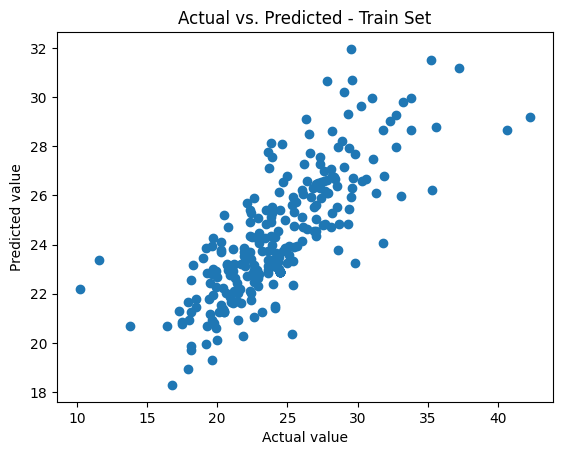

In [9]:
# calculate the predicted values for training data
y_pred_train = lin_model.predict(X_train_scaled)

# visualize the difference between actual and predicted data using scatter plot
plt.scatter(y_train, y_pred_train)
plt.xlabel("Actual value")
plt.ylabel("Predicted value")
plt.title("Actual vs. Predicted - Train Set")
plt.show()

In [ ]:
# calculate the predicted values for test data
y_pred_test = lin_model.predict(X_test_scaled)

# visualize the difference between actual and predicted data using scatter plot
plt.scatter(y_test, y_pred_test)
plt.xlabel("Actual value")
plt.ylabel("Predicted value")
plt.title("Actual vs. Predicted - Test Set")
plt.show()

Best parameters for Decision Tree Regression (LDA): {'max_depth': 3}
Test MSE: 6.8940
Test R^2: 0.5605


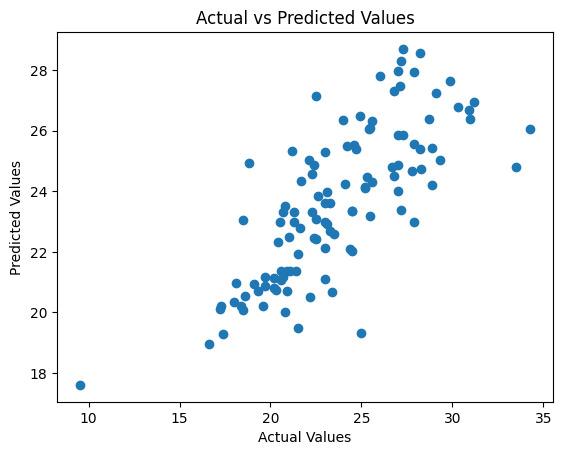

In [57]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Create decision tree model instance
clf = DecisionTreeRegressor(random_state=0)
param = {'max_depth': [3,4,5,6,7]}
grid_search = GridSearchCV(clf, param, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print("Best parameters for Decision Tree Regression (LDA):", grid_search.best_params_)

#The grid search showed that the max depth parameter should be 3
clf = DecisionTreeRegressor(max_depth=6, random_state=0)


# Create AdaBoost model instance with decision tree as the base estimator
model = AdaBoostRegressor(base_estimator=clf, random_state=0)
param = {'n_estimators': [25,50,75,100,125,150,175,200], 'learning_rate': [0.001,0.01,0.1,1]}
# grid_search = GridSearchCV(model, param, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X_train, y_train)
#print("Best parameters for Decision Tree Regression (LDA):", grid_search.best_params_)

# Fit the AdaBoost model to the training data
model = AdaBoostRegressor(base_estimator=clf, random_state=0, learning_rate=1, n_estimators=150)
model.fit(X_train, y_train)

# Predict on the training and test set
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Print the mean squared error and R^2 score for the test set
print('Test MSE: {0:0.4f}'. format(mean_squared_error(y_test, y_pred_test)))
print('Test R^2: {0:0.4f}'. format(r2_score(y_test, y_pred_test)))

# Create scatter plot of actual vs predicted values for test set
plt.scatter(y_test, y_pred_test)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()


In [55]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Following code is done for LDA

#Note testing was done prior, and the best paramaters were the following:
#Max Depth = 5, Learning Rate = 0.001 and N_Estimators = 200
#The following code only runs it for these 3 hyperparameters

#Performs Pruning to find the best maximum depth for the decision tree
treeLDAPruning = DecisionTreeRegressor(max_depth = 3)
param_grid_lda_pruning = {'max_depth': [3,4,5,6,7]} 
grid_search = GridSearchCV(treeLDAPruning, param_grid_lda_pruning, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

#Outputs value and creates the new decision tree
print("Best parameters for Decision Tree Regression (LDA):", grid_search.best_params_)
bestTreePruning = grid_search.best_estimator_

print('Testing accuracy: ', grid_search.score(X_train, y_train))
print('Validation Accuracy: ', grid_search.best_score_)

# Performs boosting
ada = AdaBoostRegressor(base_estimator=treeLDAPruning, random_state=42)
param_grid_lda_boosting = {'n_estimators': [25,50,75,100,125,150,175,200], 'learning_rate': [0.001,0.01,0.1,1]}
grid_search = GridSearchCV(ada, param_grid_lda_boosting, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

#Outputs the best hyperparameters (for learning rate and number of estimators) for boosting
print("Best parameters for AdaBoost (LDA):", grid_search.best_params_)
bestTreeBoosting = grid_search.best_estimator_

# Evaluates performance of best model on test set
Y_pred_lda = bestTreeBoosting.predict(X_test)
r2_lda = r2_score(y_test, Y_pred_lda)
print("Test set performance LDA (R^2):", r2_lda)
mse_lda = mean_squared_error(y_test, Y_pred_lda)
print("Test set performance LDA (MSE):", mse_lda)

Best parameters for Decision Tree Regression (LDA): {'max_depth': 3}
Testing accuracy:  -8.472147100604259
Validation Accuracy:  -15.46449196796336
Best parameters for AdaBoost (LDA): {'learning_rate': 1, 'n_estimators': 150}
Test set performance LDA (R^2): 0.4773288845155983
Test set performance LDA (MSE): 8.198366032000804
